# Replication of Regression from Inflation Expectation Paper

## Data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [2]:
#Read in data
df=pd.read_csv("data/data.csv")

In [3]:
#Period between 1984:1 to 2012:12
cleaned_data=df[(df["yyyymm"] >= 198401)&(df["yyyymm"] <= 201212)]
#Only keep first time responces
cleaned_data=cleaned_data[cleaned_data["datepr"].isnull()]

In [4]:
#Extra Transforms

#Age
cleaned_data["AGE2"] = cleaned_data["AGE"]*cleaned_data["AGE"]
cleaned_data["AGE3"] = cleaned_data["AGE2"]*cleaned_data["AGE"]

#Inflation DLZ
cleaned_data["PX1_ZLB"] = cleaned_data["PX1"]*cleaned_data["ZLB"]

trans = ["AGE2","AGE3","PX1_ZLB"]

In [5]:
#Inflation Expectation
pi=["PX1","PX1_ZLB"]

In [6]:
#Control for demographics

#Age cubed left out for convergence issues. Has almost 0 effect
control = ["SEX","MARRY","ECLGRD","AFRICAN","HISPANIC","NATIVE","ASIAN","WEST",
       "NORTHEAST","SOUTH","FAMSIZE","AGE","AGE2","INCOME"]

In [7]:
#other controls
ocontrol = ["ZLB","PEXP","RINC","RATEX","BUS12","BUS5","UNEMP","PAGO","GOVT",
            "BUS12AG","PX1DISP","VXO","FFR","UNRATE","INFLATION","INFLVOLA","CPIDURABLES"]

In [8]:
#Indep Variables
x = cleaned_data[pi+ocontrol+control]
y = cleaned_data.DUR

In [9]:
#Dependent Variable
pd.concat([x,y], axis=1).dropna().DUR.value_counts()

 1.0    50554
-1.0    14681
 0.0     2440
Name: DUR, dtype: int64

In [10]:
y.dropna().value_counts()

 1.0    72115
-1.0    22450
 0.0     4527
Name: DUR, dtype: int64

## Probit Model

In [11]:
model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs', maxiter = 500000)
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.624525
         Iterations: 108
         Function evaluations: 118
         Gradient evaluations: 118
                             OrderedModel Results                             
Dep. Variable:                    DUR   Log-Likelihood:                -42265.
Model:                   OrderedModel   AIC:                         8.460e+04
Method:            Maximum Likelihood   BIC:                         8.492e+04
Date:                Wed, 11 May 2022                                         
Time:                        10:06:25                                         
No. Observations:               67675                                         
Df Residuals:                   67640                                         
Df Model:                          35                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

In [12]:
res.bse

PX1            0.001461
PX1_ZLB        0.003083
ZLB            0.031398
PEXP           0.009083
RINC           0.008273
RATEX          0.007439
BUS12          0.006804
BUS5           0.006781
UNEMP          0.008948
PAGO           0.006755
GOVT           0.008759
BUS12AG        0.000334
PX1DISP        0.014579
VXO            0.000757
FFR            0.003571
UNRATE         0.006490
INFLATION      0.006079
INFLVOLA       0.006579
CPIDURABLES    0.001622
SEX            0.010934
MARRY          0.013259
ECLGRD         0.011959
AFRICAN        0.019606
HISPANIC       0.024837
NATIVE         0.055192
ASIAN          0.039057
WEST           0.015850
NORTHEAST      0.016074
SOUTH          0.013937
FAMSIZE        0.004703
AGE            0.001942
AGE2           0.000019
INCOME         0.008115
-1.0/0.0       0.083501
0.0/1.0        0.019779
dtype: float64

In [13]:
model.start_params

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.78259028, -2.14152527])

In [14]:
num_of_thresholds = 2
model.transform_threshold_params(res.params[-num_of_thresholds:])

array([       -inf, -1.46981365, -1.34185356,         inf])

# Robustness Checks

## Excluding Idiosyncratic Expecttions Controls

In [15]:
model_data = pd.concat([x,y],axis=1)

In [16]:
#Excluding Policy Trust
model_data = model_data.drop(["GOVT"],axis=1)
y = model_data["DUR"]
x = model_data.drop(["DUR"],axis=1)

model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs')
#print(res.summary())

Optimization terminated successfully.
         Current function value: 0.626448
         Iterations: 101
         Function evaluations: 109
         Gradient evaluations: 109


In [17]:
#Excluding All idiosyncratic variables
model_data = model_data.drop(["PEXP","RINC","RATEX","BUS12","BUS5","UNEMP"],axis=1)
y = model_data["DUR"]
x = model_data.drop(["DUR"],axis=1)

model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs')
#print(res.summary())

Optimization terminated successfully.
         Current function value: 0.651363
         Iterations: 93
         Function evaluations: 100
         Gradient evaluations: 100


In [18]:
#Reset
x = cleaned_data[pi+ocontrol+control]
y = cleaned_data["DUR"]
model_data = pd.concat([x,y],axis=1)

In [19]:
# With Gas Price Expectations, Home Ownership and sub prob
model_data = pd.concat([cleaned_data[["GAS1","HOMEOWN","PINC2","PJOB"]],model_data], axis=1)
model_data = model_data[cleaned_data["yyyymm"] >= 199801]

y = model_data["DUR"]
x = model_data.drop(["DUR"],axis=1)

model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs')
#print(res.summary())

Optimization terminated successfully.
         Current function value: 0.677328
         Iterations: 109
         Function evaluations: 116
         Gradient evaluations: 116


In [20]:
#Reset
x = cleaned_data[pi+ocontrol+control]
y = cleaned_data["DUR"]
model_data = pd.concat([x,y],axis=1)

In [21]:
#5 year inflation expectations instead of one year
model_data = model_data[cleaned_data["yyyymm"] >= 199004]


y = model_data["DUR"]
x = model_data.drop(["DUR"],axis=1)


x = x.drop(["PX1","PX1_ZLB"],axis = 1)
x["PX5"] = cleaned_data["PX5"]
x["PX5_ZLB"] = x["PX5"] * x["ZLB"]

model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs')
#print(res.summary())

Optimization terminated successfully.
         Current function value: 0.646885
         Iterations: 98
         Function evaluations: 106
         Gradient evaluations: 106


## Cross Sectional Heterogenity

In [22]:
#Reset
x = cleaned_data[pi+ocontrol+control]
y = cleaned_data["DUR"]
model_data = pd.concat([x,y],axis=1)

In [23]:
#Old
model_old = model_data[model_data["AGE"] > 48]

y = model_old["DUR"]
x = model_old.drop(["DUR"],axis=1)

model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs')
#print(res.summary())

Optimization terminated successfully.
         Current function value: 0.656675
         Iterations: 112
         Function evaluations: 122
         Gradient evaluations: 122


In [24]:
#Young
model_young = model_data[model_data["AGE"] < 48]

y = model_young["DUR"]
x = model_young.drop(["DUR"],axis=1)

model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs')
#print(res.summary())

Optimization terminated successfully.
         Current function value: 0.599970
         Iterations: 91
         Function evaluations: 98
         Gradient evaluations: 98


In [25]:
#College
model_college = model_data[model_data["ECLGRD"] == 1]
model_college = model_college.drop(["ECLGRD"],axis = 1)

y = model_college["DUR"]
x = model_college.drop(["DUR"],axis=1)

model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs')
#print(res.summary())

Optimization terminated successfully.
         Current function value: 0.627368
         Iterations: 94
         Function evaluations: 104
         Gradient evaluations: 104


In [26]:
#No College
model_nocollege = model_data[model_data["ECLGRD"] == 0]
model_nocollege = model_nocollege.drop(["ECLGRD"],axis = 1)

y = model_nocollege["DUR"]
x = model_nocollege.drop(["DUR"],axis=1)

model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs')
#print(res.summary())

Optimization terminated successfully.
         Current function value: 0.621165
         Iterations: 98
         Function evaluations: 107
         Gradient evaluations: 107


In [27]:
#Top 20% income
model_top = model_data[cleaned_data["income"] >= cleaned_data["income"].quantile(q=0.8)]

y = model_top["DUR"]
x = model_top.drop(["DUR"],axis=1)

model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs')
#print(res.summary())

Optimization terminated successfully.
         Current function value: 0.636086
         Iterations: 96
         Function evaluations: 105
         Gradient evaluations: 105


In [28]:
#Bottom 20% income
model_bottom = model_data[cleaned_data["income"] <= cleaned_data["income"].quantile(q=0.2)]

y = model_bottom["DUR"]
x = model_bottom.drop(["DUR"],axis=1)

model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs')
#print(res.summary())

Optimization terminated successfully.
         Current function value: 0.640264
         Iterations: 108
         Function evaluations: 113
         Gradient evaluations: 113


# Further Robustness Tests

## Residuals

In [39]:
#Reset
x = cleaned_data[pi+ocontrol+control]
y = cleaned_data["DUR"]
model_data = pd.concat([x,y],axis=1)

In [40]:
#Model
model = OrderedModel(y,x,distr='probit',missing="drop")
res = model.fit(method='bfgs')

Optimization terminated successfully.
         Current function value: 0.624525
         Iterations: 108
         Function evaluations: 118
         Gradient evaluations: 118


In [41]:
#Predict
y_hat = res.predict(x)

In [247]:
#Get avalible residuals
y_hat = y_hat.dropna()
y_real = y[y_hat.index]
y_res = np.array((y_real+1))-np.array(y_hat).argmax(1)
y_res = y_res[~np.isnan(y_res)]
y_res = pd.DataFrame(y_res)

Text(0, 0.5, 'Observation Count')

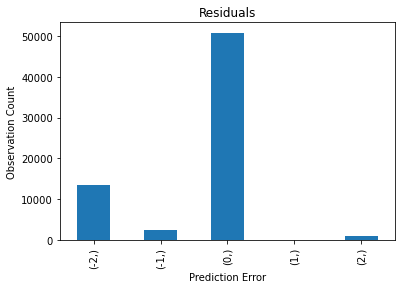

In [248]:
#Note negative bias
y_res = y_res.astype("int")
y_res = np.array(y_res)
y_res = np.transpose(np.sort(np.transpose(y_res)))
y_res = pd.DataFrame(y_res, columns =["Values"])
y_res.value_counts().sort_index().plot(kind="bar")
plt.title('Residuals')
plt.grid(False)
plt.xlabel("Prediction Error")
plt.ylabel("Observation Count")


In [34]:
y_res.value_counts()
y_res.mean()

0   -0.397813
dtype: float64

## Check OLS Fitting (Ignore only done to check dataquality)

In [35]:
#Reset
x = cleaned_data[pi+ocontrol+control]
y = cleaned_data["DUR"]
model_data = pd.concat([x,y],axis=1)

In [36]:
mod = sm.OLS(y, x, missing="drop")
test=mod.fit()

In [37]:
test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    DUR   R-squared (uncentered):                   0.352
Model:                            OLS   Adj. R-squared (uncentered):              0.351
Method:                 Least Squares   F-statistic:                              1112.
Date:                Wed, 11 May 2022   Prob (F-statistic):                        0.00
Time:                        10:12:42   Log-Likelihood:                         -80116.
No. Observations:               67675   AIC:                                  1.603e+05
Df Residuals:                   67642   BIC:                                  1.606e+05
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
PX1             0.0010      0.001      1.149      0.250      -0.001       0.003
PX1_ZLB        -0.0105      0.002     -5.522      0.000      -0.014      -0.007
ZLB            -0.0011      0.018     -0.059      0.953      -0.037       0.035
PEXP            0.0269      0.005      5.139      0.000       0.017       0.037
RINC            0.0059      0.005      1.259      0.208      -0.003       0.015
RATEX           0.0356      0.004      8.381      0.000       0.027       0.044
BUS12           0.0765      0.004     19.514      0.000       0.069       0.084
BUS5            0.0348      0.004      9.048      0.000       0.027       0.042
UNEMP          -0.0378      0.005     -7.402      0.000      -0.048      -0.028
PAGO            0.0736      0.004     18.794      0.000       0.066       0.081
GOVT            0.0598      0.005     11.985      0.000       0.050       0.070
BUS12AG         0.0023      0.000     12.416      0.000       0.002       0.003
PX1DISP         0.0130      0.008      1.667      0.096      -0.002       0.028
VXO            -0.0022      0.000     -4.908      0.000      -0.003      -0.001
FFR             0.0051      0.002      2.548      0.011       0.001       0.009
UNRATE         -0.0101      0.004     -2.804      0.005      -0.017      -0.003
INFLATION       0.0066      0.003      1.927      0.054      -0.000       0.013
INFLVOLA       -0.0198      0.004     -4.922      0.000      -0.028      -0.012
CPIDURABLES     0.0025      0.001      2.790      0.005       0.001       0.004
SEX            -0.0288      0.006     -4.658      0.000      -0.041      -0.017
MARRY          -0.0353      0.007     -4.806      0.000      -0.050      -0.021
ECLGRD         -0.0320      0.007     -4.739      0.000      -0.045      -0.019
AFRICAN         0.0074      0.011      0.653      0.514      -0.015       0.030
HISPANIC       -0.0433      0.014     -2.998      0.003      -0.072      -0.015
NATIVE         -0.0079      0.032     -0.246      0.806      -0.071       0.055
ASIAN          -0.0585      0.023     -2.553      0.011      -0.103      -0.014
WEST           -0.0130      0.009     -1.438      0.150      -0.031       0.005
NORTHEAST       0.0063      0.009      0.690      0.490      -0.012       0.024
SOUTH           0.0037      0.008      0.475      0.634      -0.012       0.019
FAMSIZE        -0.0046      0.003     -1.729      0.084      -0.010       0.001
AGE             0.0062      0.001      6.269      0.000       0.004       0.008
AGE2        -4.678e-05   1.02e-05     -4.565      0.000   -6.69e-05   -2.67e-05
INCOME          0.0727      0.004     17.507      0.000       0.065       0.081
==============================================================================
Omnibus:                 